In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
df=pd.read_csv("./train.csv",parse_dates=["Date"],index_col=[0])

In [3]:
print(df.index.freq)

None


In [4]:
df.shape

(5203, 5)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2001-01-25,356.730774,362.980774,352.403839,353.365387,197.122452
2001-01-26,357.211548,360.096161,342.788452,343.269226,191.490234
2001-01-29,345.153839,355.769226,338.461548,341.384613,190.439011
2001-01-30,344.307678,355.923065,341.692322,355.769226,198.463318
2001-01-31,359.615387,361.153839,350.461548,353.692322,197.304749


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-23,99.529999,104.080002,99.519997,102.959999,102.789993
2021-09-24,102.660004,104.199997,102.599998,103.800003,103.709198
2021-09-27,104.550003,106.330002,104.389999,105.349998,105.257835
2021-09-28,105.290001,106.750000,104.730003,105.730003,105.637512
2021-09-29,106.000000,107.000000,105.309998,106.279999,106.187027


In [7]:
test_split=round(len(df)*0.20)

In [8]:
test_split

1041

In [9]:
df_for_training=df[:-1041]
df_for_testing=df[-1041:]

In [10]:
print(df_for_training.shape)
print(df_for_testing.shape)

(4162, 5)
(1041, 5)


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [12]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [13]:
df_for_training_scaled

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       ...,
       [0.40689652, 0.40362224, 0.41960282, 0.40436458, 0.7632948 ],
       [0.40517242, 0.39995691, 0.41832161, 0.4075738 , 0.76889077],
       [0.40862067, 0.39974127, 0.41426436, 0.39880189, 0.75359571]])

In [14]:
df_for_training_scaled.shape

(4162, 5)

In [15]:
df_for_testing_scaled.shape

(1041, 5)

In [16]:
#这里注意，是多变量预测单变量，所以这里有一些修改
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])#分X和Y的时候，X就是当前的数据，Y也是当前的数据，然后只用当前的X来预测Y有点像BP神经网络，但是这个考虑到了时间的因素
            dataY.append(dataset[i-n_past:i,0])
    return np.array(dataX),np.array(dataY)        

In [17]:
trainX,trainY=createXY(df_for_training_scaled,1)#用当前X来预测Y

In [19]:
print(trainX)

[[[0.86281807 0.85292546 0.8403402  0.82180889]]

 [[0.85473269 0.82623316 0.8122593  0.79289309]]

 [[0.84260459 0.81422168 0.80701755 0.78749611]]

 ...

 [[0.40146615 0.42024345 0.4058622  0.76590638]]

 [[0.40362224 0.41960282 0.40436458 0.7632948 ]]

 [[0.39995691 0.41832161 0.4075738  0.76889077]]]


In [20]:
print(trainY)

[[0.85398707]
 [0.85533406]
 [0.82155169]
 ...
 [0.40926723]
 [0.40689652]
 [0.40517242]]


In [37]:
testX,testY=createXY(df_for_testing_scaled,1)

In [38]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (4161, 1, 4)
trainY Shape--  (4161, 1)


In [39]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (1040, 1, 4)
testY Shape--  (1040, 1)


In [40]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.86281807 0.85292546 0.8403402  0.82180889]]

trainY[0]--  [0.85398707]


In [43]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [49]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [1,20],
              'epochs' : [81,82],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\86157\AppData\Local\Temp\ipykernel_30644\2145507911.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [50]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/81
2080/2080 [==============================] - 5s 2ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2/81
2080/2080 [==============================] - 3s 2ms/step - loss: 5.5253e-04 - val_loss: 6.2083e-04
Epoch 3/81
2080/2080 [==============================] - 3s 1ms/step - loss: 3.4065e-04 - val_loss: 0.0011
Epoch 4/81
2080/2080 [==============================] - 3s 1ms/step - loss: 2.2107e-04 - val_loss: 3.5668e-04
Epoch 5/81
2080/2080 [==============================] - 3s 1ms/step - loss: 1.8147e-04 - val_loss: 2.8505e-04
Epoch 6/81
2080/2080 [==============================] - 3s 1ms/step - loss: 1.4957e-04 - val_loss: 4.3336e-04
Epoch 7/81
2080/2080 [==============================] - 3s 1ms/step - loss: 1.4915e-04 - val_loss: 2.2518e-04
Epoch 8/81
2080/2080 [==============================] - 3s 1ms/step - loss: 1.3439e-04 - val_loss: 3.8325e-04
Epoch 9/81
2080/2080 [==============================] - 3s 1ms/step - loss: 1.3638e-04 - val_loss: 1.0761e-04
Epoch 10/81
2080/2080 

In [51]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 81, 'optimizer': 'adam'}

In [52]:
my_model=grid_search.best_estimator_.model

In [53]:
my_model

In [54]:
prediction=my_model.predict(testX)

33/33 [==============================] - 0s 781us/step


In [55]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.39728257]
 [0.39896664]
 [0.39498776]
 ...
 [0.15229398]
 [0.15754312]
 [0.1585716 ]]

Prediction Shape- (1040, 1)


In [56]:
testY.shape

(1040, 1)

In [57]:
#scaler.inverse_transform(prediction)

In [58]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [59]:
prediction_copies_array.shape

(1040, 5)

In [60]:
prediction_copies_array

array([[0.39728257, 0.39728257, 0.39728257, 0.39728257, 0.39728257],
       [0.39896664, 0.39896664, 0.39896664, 0.39896664, 0.39896664],
       [0.39498776, 0.39498776, 0.39498776, 0.39498776, 0.39498776],
       ...,
       [0.15229398, 0.15229398, 0.15229398, 0.15229398, 0.15229398],
       [0.15754312, 0.15754312, 0.15754312, 0.15754312, 0.15754312],
       [0.1585716 , 0.1585716 , 0.1585716 , 0.1585716 , 0.1585716 ]],
      dtype=float32)

In [61]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]#预测的结果是缩小的，这里要逆变换回去，因为前面复制了5列，这里取第一列就可以了[:,0]

In [62]:
pred

array([193.72238 , 194.32347 , 192.90332 , ..., 106.28031 , 108.153854,
       108.52094 ], dtype=float32)

In [63]:
original_copies_array = np.repeat(testY,5, axis=-1)#test的结果也是线复制5列，这样菜满足前面fit好的缩放函数，然后这里再和上面一样进行逆变换，取第一列

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [64]:
pred

array([193.72238 , 194.32347 , 192.90332 , ..., 106.28031 , 108.153854,
       108.52094 ], dtype=float32)

In [65]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [193.72238  194.32347  192.90332  ... 106.28031  108.153854 108.52094 ]

Original Values--  [195.384613 194.461533 193.92308  ... 102.660004 104.550003 105.290001]


In [66]:
import matplotlib.pyplot as plt

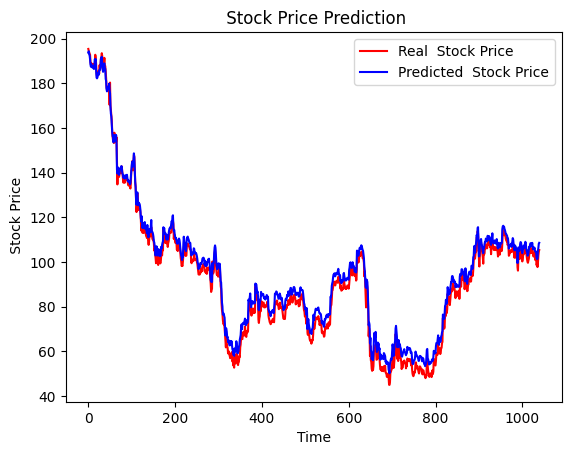

In [67]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [72]:
df_30_days_past=df.iloc[-1:,:]

In [73]:
df_30_days_past

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-29,106.0,107.0,105.309998,106.279999,106.187027


In [74]:
df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.shape

(30, 4)

In [75]:
df_30_days_future

,High,Low,Close,Adj Close
Date,,,,
2021-09-30,107.089996,102.949997,103.029999,102.939865
2021-10-01,106.389999,103.669998,105.820000,105.727425
2021-10-04,107.080002,104.599998,104.900002,104.808235
2021-10-05,106.000000,103.750000,104.900002,104.808235
2021-10-06,104.419998,102.059998,104.330002,104.238731
2021-10-07,106.529999,104.330002,105.510002,105.417702
2021-10-08,106.220001,104.660004,104.720001,104.628387
2021-10-11,105.760002,103.970001,104.080002,103.988953
2021-10-12,104.040001,101.559998,102.720001,102.630142


In [76]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [77]:
full_df.shape

(31, 5)

In [78]:
full_df.tail()

,0,1,2,3,4
26,NaN,0.143640,0.164162,0.150135,0.349458
27,NaN,0.152749,0.171268,0.159953,0.367565
28,NaN,0.154599,0.175349,0.159063,0.365924
29,NaN,0.171024,0.181345,0.167045,0.380645
30,NaN,0.161242,0.174766,0.160565,0.368694


In [79]:
full_df

,0,1,2,3,4
0,0.151509,0.145321,0.166993,0.153111,0.354947
1,NaN,0.145574,0.160442,0.144071,0.338276
2,NaN,0.143611,0.162441,0.151831,0.352587
3,NaN,0.145546,0.165022,0.149273,0.347868
4,NaN,0.142518,0.162663,0.149273,0.347868
5,NaN,0.138090,0.157971,0.147687,0.344944
6,NaN,0.144004,0.164273,0.150969,0.350997
7,NaN,0.143135,0.165189,0.148772,0.346944
8,NaN,0.141846,0.163274,0.146992,0.343662
9,NaN,0.137025,0.156583,0.143209,0.336685


In [80]:
full_df.shape

(31, 5)

In [81]:
full_df_scaled_array=full_df.values

In [82]:
full_df_scaled_array.shape


(31, 5)

In [83]:
len(full_df_scaled_array)

31

In [84]:
all_data=[]
time_step=1
for i in range(1,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,1:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    #print(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 15ms/step


In [85]:
all_data

[array([[0.15966299]], dtype=float32),
 array([[0.15665498]], dtype=float32),
 array([[0.15683585]], dtype=float32),
 array([[0.15878749]], dtype=float32),
 array([[0.15628088]], dtype=float32),
 array([[0.15202975]], dtype=float32),
 array([[0.15777028]], dtype=float32),
 array([[0.15763512]], dtype=float32),
 array([[0.15611053]], dtype=float32),
 array([[0.15072879]], dtype=float32),
 array([[0.14906973]], dtype=float32),
 array([[0.1511347]], dtype=float32),
 array([[0.15542936]], dtype=float32),
 array([[0.15336251]], dtype=float32),
 array([[0.15462333]], dtype=float32),
 array([[0.15657356]], dtype=float32),
 array([[0.15576014]], dtype=float32),
 array([[0.15269697]], dtype=float32),
 array([[0.1558199]], dtype=float32),
 array([[0.16523924]], dtype=float32),
 array([[0.15928054]], dtype=float32),
 array([[0.15469396]], dtype=float32),
 array([[0.15564919]], dtype=float32),
 array([[0.15930057]], dtype=float32),
 array([[0.15989268]], dtype=float32),
 array([[0.15813091]], dtyp

In [86]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]

In [91]:
y_pred_future_30_days

array([108.910484, 107.83686 , 107.90141 , 108.598   , 107.70333 ,
       106.186005, 108.23493 , 108.18669 , 107.642525, 105.721664,
       105.1295  , 105.86654 , 107.39941 , 106.6617  , 107.11171 ,
       107.8078  , 107.51746 , 106.42415 , 107.538795, 110.90078 ,
       108.77398 , 107.136925, 107.47787 , 108.78113 , 108.99246 ,
       108.36365 , 108.14131 , 110.97539 , 111.909485, 115.85833 ],
      dtype=float32)

In [92]:
import matplotlib.pyplot as plt

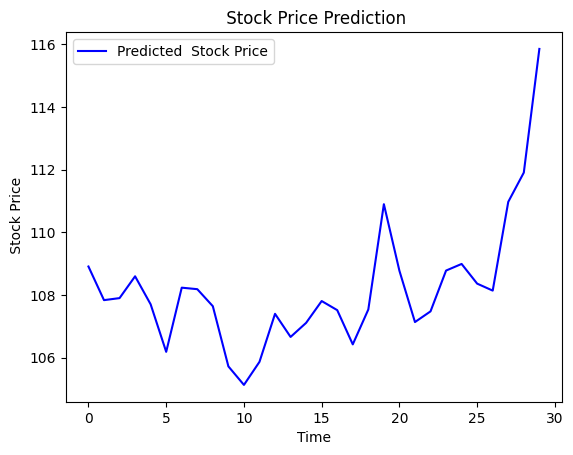

In [93]:
plt.plot(y_pred_future_30_days, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# END!!!!